In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import (
    StructType, StructField, StringType,
    IntegerType, DoubleType
)
from pyspark.sql.functions import broadcast

import matplotlib.pyplot as plt
import os
# base_path = "abfss://f4041c98-2c4f-44a4-82ec-ab26f8d5d0b3@onelake.dfs.fabric.microsoft.com/d3c25d34-1652-45f9-b4f3-58b4aedb4efa/Files/bronze/"
spark = SparkSession.builder.appName("ProductsSilverPipeline").getOrCreate()

StatementMeta(, ad4442f1-4bb5-40f7-aa0f-3439f7772b6c, 3, Finished, Available, Finished)

In [2]:
# products_schema = StructType([
#     StructField("product_id", StringType(), False),
#     StructField("product_category_name", StringType(), True),
#     StructField("product_name_lenght", IntegerType(), True),
#     StructField("product_description_lenght", IntegerType(), True),
#     StructField("product_photos_qty", IntegerType(), True),
#     StructField("product_weight_g", DoubleType(), True),
#     StructField("product_length_cm", DoubleType(), True),
#     StructField("product_height_cm", DoubleType(), True),
#     StructField("product_width_cm", DoubleType(), True),
# ])

StatementMeta(, ad4442f1-4bb5-40f7-aa0f-3439f7772b6c, 4, Finished, Available, Finished)

In [3]:
# products_df = spark.read.csv(
#     "olist_products_dataset.csv" if base_path == "" else os.path.join(base_path,  "olist_products_dataset.csv"),
#     header=True,
#     schema=products_schema
# ).repartition(20)

products_df = spark.read.table("br_products")

print("Products schema:")
products_df.printSchema()

StatementMeta(, ad4442f1-4bb5-40f7-aa0f-3439f7772b6c, 5, Finished, Available, Finished)

Products schema:
root
 |-- product_id: string (nullable = true)
 |-- product_category_name: string (nullable = true)
 |-- product_name_lenght: integer (nullable = true)
 |-- product_description_lenght: integer (nullable = true)
 |-- product_photos_qty: integer (nullable = true)
 |-- product_weight_g: integer (nullable = true)
 |-- product_length_cm: integer (nullable = true)
 |-- product_height_cm: integer (nullable = true)
 |-- product_width_cm: integer (nullable = true)



In [4]:
# translation_schema = StructType([
#     StructField("product_category_name", StringType(), True),
#     StructField("product_category_name_english", StringType(), True),
# ])

# translation_df = spark.read.csv(
#     "product_category_name_translation.csv" if base_path == "" else os.path.join(base_path, "product_category_name_translation.csv"),
#     header=True,
#     schema=translation_schema
# )
translation_df = spark.read.table("br_product_category_name_translation")

StatementMeta(, ad4442f1-4bb5-40f7-aa0f-3439f7772b6c, 6, Finished, Available, Finished)

In [5]:
# updated. Join products with English category names. BEST PRACTICE: Use broadcast join for small dimension tables. 
# Broadcasting avoids shuffle by sending small table to all nodes

products_df = (
    products_df
    .join(
        broadcast(translation_df), 
        on="product_category_name", 
        how="left"
    )
    .withColumnRenamed("product_category_name_english", "product_category_english")
)

StatementMeta(, ad4442f1-4bb5-40f7-aa0f-3439f7772b6c, 7, Finished, Available, Finished)

In [6]:
quarantine_df = products_df.filter(
    (F.col("product_id").isNull()) |
    (F.col("product_weight_g").isNull() | (F.col("product_weight_g") <= 0)) |
    (F.col("product_length_cm").isNull() | (F.col("product_length_cm") <= 0)) |
    (F.col("product_height_cm").isNull() | (F.col("product_height_cm") <= 0)) |
    (F.col("product_width_cm").isNull() | (F.col("product_width_cm") <= 0)) |
    (F.col("product_category_english").isNull())
)

clean_products_df = products_df.subtract(quarantine_df)

print("Quarantined rows:", quarantine_df.count())
print("Clean rows:", clean_products_df.count())

StatementMeta(, ad4442f1-4bb5-40f7-aa0f-3439f7772b6c, 8, Finished, Available, Finished)

Quarantined rows: 628
Clean rows: 32323


In [7]:
clean_products_df = clean_products_df.withColumn(
    "product_volume_cm3",
    (F.col("product_length_cm") * F.col("product_height_cm") * F.col("product_width_cm"))
)

clean_products_df = clean_products_df.withColumn(
    "size_category",
    F.when(F.col("product_volume_cm3") < 1000, "Small")
     .when((F.col("product_volume_cm3") >= 1000) & (F.col("product_volume_cm3") <= 5000), "Medium")
     .otherwise("Large")
)

clean_products_df = clean_products_df.withColumn(
    "weight_category",
    F.when(F.col("product_weight_g") < 500, "Light")
     .when((F.col("product_weight_g") >= 500) & (F.col("product_weight_g") <= 2000), "Medium")
     .otherwise("Heavy")
)

# capitalize product_category_english, remove underscores and set to title case
clean_products_df = clean_products_df.withColumn(
    "product_category_english",
    F.initcap(F.regexp_replace(F.col("product_category_english"), "_", " "))
)

StatementMeta(, ad4442f1-4bb5-40f7-aa0f-3439f7772b6c, 9, Finished, Available, Finished)

In [8]:
#added - rename typo columns for downstream consistency

print(clean_products_df.columns)

clean_products_df = (
    clean_products_df
    .withColumnRenamed("product_name_lenght", "product_name_length")
    .withColumnRenamed("product_description_lenght", "product_description_length")
)

StatementMeta(, ad4442f1-4bb5-40f7-aa0f-3439f7772b6c, 10, Finished, Available, Finished)

['product_category_name', 'product_id', 'product_name_lenght', 'product_description_lenght', 'product_photos_qty', 'product_weight_g', 'product_length_cm', 'product_height_cm', 'product_width_cm', 'product_category_english', 'product_volume_cm3', 'size_category', 'weight_category']


In [9]:
# silver_path = os.path.join(base_path, "silver_olist_products")
# quarantine_path = os.path.join(base_path, "quarantine_olist_products")
# clean_products_df.write.mode("overwrite").parquet(silver_path)
# quarantine_df.write.mode("overwrite").parquet(quarantine_path)

# Added: Write clean + quarantine to Silver Lakehouse tables
# Allow Delta to update schema
(
    clean_products_df.write
    .format("delta")
    .mode("overwrite")
    .option("overwriteSchema", "true")   # ✅ force schema update
    # .saveAsTable("lakehouse_olist.sl_products")
    .saveAsTable("lh_silver_olist.sl_product")
)

quarantine_df.write.format("delta").mode("overwrite").save("Tables/qr_products")

print("✅ Silver tables saved: sl_products, qr_products")

StatementMeta(, ad4442f1-4bb5-40f7-aa0f-3439f7772b6c, 11, Finished, Available, Finished)

✅ Silver tables saved: sl_products, qr_products


In [10]:
# spark.read.table("lakehouse_olist.sl_products").printSchema()
spark.read.table("lh_silver_olist.sl_products").printSchema()

StatementMeta(, ad4442f1-4bb5-40f7-aa0f-3439f7772b6c, 12, Finished, Available, Finished)

root
 |-- product_category_name: string (nullable = true)
 |-- product_id: string (nullable = true)
 |-- product_name_length: integer (nullable = true)
 |-- product_description_length: integer (nullable = true)
 |-- product_photos_qty: integer (nullable = true)
 |-- product_weight_g: integer (nullable = true)
 |-- product_length_cm: integer (nullable = true)
 |-- product_height_cm: integer (nullable = true)
 |-- product_width_cm: integer (nullable = true)
 |-- product_category_english: string (nullable = true)
 |-- product_volume_cm3: integer (nullable = true)
 |-- size_category: string (nullable = true)
 |-- weight_category: string (nullable = true)



In [11]:
display(clean_products_df[["product_category_english"]].limit(10)) # dataframe UI display

StatementMeta(, ad4442f1-4bb5-40f7-aa0f-3439f7772b6c, 13, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, f5591d36-7409-4b27-981b-5e0b39309fac)

In [12]:
category_counts = (
    clean_products_df.groupBy("product_category_english")
    .count()
    .orderBy(F.desc("count"))
)

size_counts = (
    clean_products_df.groupBy("size_category")
    .count()
    .orderBy(F.desc("count"))
)

print("Top categories:")
category_counts.show(10, truncate=False)

print("Size distribution:")
size_counts.show()

StatementMeta(, ad4442f1-4bb5-40f7-aa0f-3439f7772b6c, 14, Finished, Available, Finished)

Top categories:
+------------------------+-----+
|product_category_english|count|
+------------------------+-----+
|Bed Bath Table          |3025 |
|Sports Leisure          |2867 |
|Furniture Decor         |2657 |
|Health Beauty           |2444 |
|Housewares              |2335 |
|Auto                    |1900 |
|Computers Accessories   |1639 |
|Toys                    |1411 |
|Watches Gifts           |1329 |
|Telephony               |1134 |
+------------------------+-----+
only showing top 10 rows

Size distribution:
+-------------+-----+
|size_category|count|
+-------------+-----+
|        Large|19069|
|       Medium|11143|
|        Small| 2111|
+-------------+-----+



StatementMeta(, ad4442f1-4bb5-40f7-aa0f-3439f7772b6c, 15, Finished, Available, Finished)

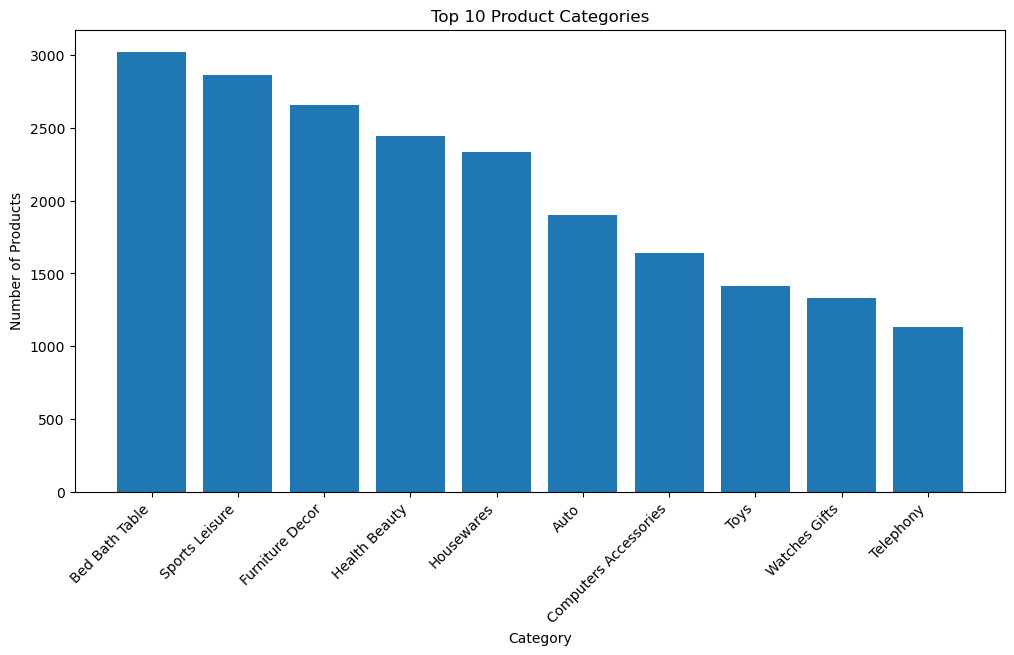

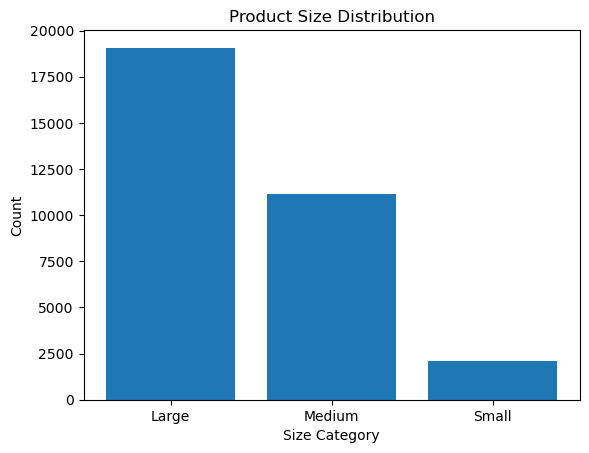

In [13]:
cat_pd = category_counts.limit(10).toPandas()
plt.figure(figsize=(12, 6))
plt.bar(cat_pd["product_category_english"], cat_pd["count"])
plt.title("Top 10 Product Categories")
plt.xlabel("Category")
plt.ylabel("Number of Products")
plt.xticks(rotation=45, ha="right")
plt.show()

size_pd = size_counts.toPandas()
plt.bar(size_pd["size_category"], size_pd["count"])
plt.title("Product Size Distribution")
plt.xlabel("Size Category")
plt.ylabel("Count")
plt.show()